In [22]:
import batoid
import numpy as np
import os
import yaml
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets
%matplotlib inline

In [23]:
D = 0.1
m0 = batoid.ConstMedium(1.000277)  # air
w, n = np.genfromtxt(os.path.join(batoid.datadir, "media", "silica_dispersion.txt")).T
w *= 1e-6
m1 = batoid.TableMedium(w, n)
wavelength = 500e-9
n0 = m0.getN(wavelength)
n1 = m1.getN(wavelength)
R1 = 0.5  # convex entrance surface
R2 = -0.5  # convex exit surface
d = 0.01
# Lens maker equation:
f_inv = (n1-n0)*(1./R1 - 1./R2 + (n1-n0)*d/R1/R2)
f = 1/f_inv

In [24]:
print(n0, n1)

1.000277 1.4623265011100002


In [25]:
def makeSystem(focus):
    systemStr = """
    opticalSystem:
      type: CompoundOptic
      inMedium: 1.000277
      items:
        -
          type: RefractiveInterface
          surface:
            type: Sphere
            R: {R1}
          obscuration:
            type: ClearCircle
            radius: {Do2}
          inMedium: 1.000277
          outMedium: &silica
            type: SellmeierMedium
            B1: 0.6961663
            B2: 0.4079426
            B3: 0.8974794
            C1: 0.00467914825849
            C2: 0.013512063073959999
            C3: 97.93400253792099
          name: L1
        -
          type: RefractiveInterface
          surface:
            type: Sphere
            R: {R2}
          obscuration:
            type: ClearCircle
            radius: {Do2}
          coordSys:
            z: {d}
          inMedium: *silica
          outMedium: 1.000277
          name: L2
        -
          type: Detector
          surface:
            type: Plane
          obscuration:
            type: ClearCircle
            radius: {Do2}
          coordSys:
            z: {f}
          inMedium: 1.000277          
          name: D
    """.format(**dict(R1=R1, R2=R2, Do2=D/2, d=d, f=f+focus))
    config = yaml.safe_load(systemStr)
    system = batoid.parse.parse_optic(config['opticalSystem'])
    return system

In [26]:
@interact(theta_x=widgets.FloatSlider(min=-5,max=5,step=1,value=1.1, continuous_update=False),
          theta_y=widgets.FloatSlider(min=-5,max=5,step=1,value=2.2, continuous_update=False),
          wavelength=widgets.FloatSlider(min=0.4,max=0.7,step=0.05,value=0.5, continuous_update=False),
          focus=widgets.FloatSlider(min=-20, max=20, step=1,value=0.0, continuous_update=False))
def spot(theta_x, theta_y, wavelength, focus):
    """Display a spot diagram for a Newtonian telescope.

    @param theta_x  Field angle in degrees
    @param theta_y  Field angle in degrees
    @param wavelength in microns
    @param focus    Defocus distance in mm
    """
    system = makeSystem(focus*1e-3)
    dirCos = batoid.utils.fieldToDirCos(np.deg2rad(theta_x), np.deg2rad(theta_y))
    # Flip the z-cosine since we constructed our telescope to point down
    # instead of up, and hence need the initial rays to point up instead
    # of down.
    dirCos = dirCos[0:2]+(-dirCos[2],)
    rays = batoid.RayVector.asPolar(
        backDist=1.0, nrad=16, naz=64, wavelength=wavelength*1e-6,
        dirCos=dirCos,
        outer=D/2*0.999, medium=batoid.ConstMedium(1.000277)
    )
    
    system.trace(rays)
    w = ~rays.vignetted
    fig = plt.figure()
    ax = plt.axes()
    ax.scatter(1e3*(rays.x[w]-np.mean(rays.x[w])), 1e3*(rays.y[w]-np.mean(rays.y[w])), s=1)
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_xlabel("mm")
    ax.set_ylabel("mm")
    ax.set_title(r"$\theta_x = {:4.2f}\,,\theta_y = {:4.2f}\,,\lambda = {:4g}\,, f={:4.2f}$".format(theta_x, theta_y, wavelength, focus))
    ax.set_aspect('equal')    
    plt.show()

interactive(children=(FloatSlider(value=1.1, continuous_update=False, description='theta_x', max=5.0, min=-5.0…

In [27]:
import ipyvolume as ipv

In [28]:
ipv.figure(width=1000)
system = makeSystem(0)
theta_x = theta_y = 0
dirCos = batoid.utils.fieldToDirCos(np.deg2rad(theta_x), np.deg2rad(theta_y))
dirCos = dirCos[0:2]+(-dirCos[2],)
rays = batoid.RayVector.asPolar(
    backDist=1.0, nrad=2, naz=12, wavelength=500e-9,
    dirCos=dirCos,
    outer=D/2*0.99, medium=batoid.ConstMedium(1.000277)
)
tf = system.traceFull(rays)
system.draw3d(ipv)
batoid.drawTrace3d(ipv, tf, color='blue')
ipv.xlim(-0.5, 0.5)
ipv.ylim(-0.5, 0.5)
ipv.zlim(0.0, 1.0)
ipv.show()

In [29]:
# should need a phase delay of
# (n1-n0) / (2 sqrt(3) R)
(n1-n0) / (2 * np.sqrt(3) * R1) # meters of Z4

0.26676440384479083

In [30]:
def makePhaseScreen(amplitude):
    systemStr = """
    opticalSystem:
      type: CompoundOptic
      inMedium: 1.000277
      items:
        -
          type: OPDScreen
          surface:
            type: Plane
          screen:
            type: Zernike
            coef: [0.0, 0.0, 0.0, 0.0, {amplitude}]
            # R_outer: 0.05
          obscuration:
            type: ClearCircle
            radius: 0.05
          inMedium: 1.000277
          outMedium: 1.000277
          name: screen
        -
          type: Detector
          surface:
            type: Plane
          obscuration:
            type: ClearCircle
            radius: 0.2
          coordSys:
            z: 0.5
          inMedium: 1.000277          
          name: D
    """.format(amplitude=amplitude)
    config = yaml.safe_load(systemStr)
    system = batoid.parse.parse_optic(config['opticalSystem'])
    return system

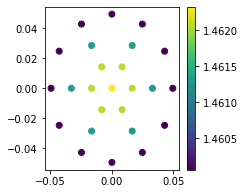

In [31]:
ipv.figure(width=1000)
# system = makePhaseScreen(-0.7e-3)
system = makePhaseScreen(-0.26676440384479083)
theta_x = theta_y = 0
dirCos = batoid.utils.fieldToDirCos(np.deg2rad(theta_x), np.deg2rad(theta_y))
dirCos = dirCos[0:2]+(-dirCos[2],)
rays = batoid.RayVector.asPolar(
    backDist=1.0, nrad=4, naz=12, wavelength=500e-9,
    dirCos=dirCos,
    outer=D/2*0.99, medium=batoid.ConstMedium(1.000277)
)
tf = system.traceFull(rays)
system.draw3d(ipv)
batoid.drawTrace3d(ipv, tf, color='blue')
ipv.xlim(-0.5, 0.5)
ipv.ylim(-0.5, 0.5)
ipv.zlim(0.0, 1.0)
ipv.show()

fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot()
s = ax.scatter(tf['screen']['out'].x, tf['screen']['out'].y, c=tf['screen']['out'].t-tf['screen']['in'].t)
plt.colorbar(s)
plt.show()

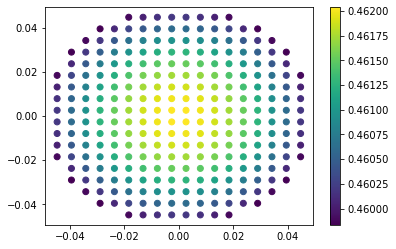

In [20]:
x = np.linspace(-0.05, 0.05, 20)
x, y = np.meshgrid(x, x)
r = np.hypot(x, y)
w = r < 0.05
x, y = x[w], y[w]
c = system['.screen'].screen.sag(x, y)
plt.scatter(x, y, c=c)
plt.colorbar()
plt.show()